In [1]:
import cv2
import platform
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tflite_runtime.interpreter as tflite

from matplotlib import pyplot as plt
from matplotlib import gridspec

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
EDGETPU_SHARED_LIB = {
  'Linux': 'libedgetpu.so.1',
  'Darwin': 'libedgetpu.1.dylib',
  'Windows': 'edgetpu.dll'
}[platform.system()]

def make_interpreter(tflite_model):
    return tflite.Interpreter(
      model_content=tflite_model,
      experimental_delegates=[
          tflite.load_delegate(EDGETPU_SHARED_LIB, {})
      ])

def create_pascal_label_colormap():
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap   

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

LABEL_NAMES = np.asarray([
    'road',
    'sidewalk',
    'building',
    'guard rail',
    'bridge',
    'pole',
    'traffic light',
    'traffic sign',
    'vegetation',
    'terrain',
    'sky',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'trailer',
    'motorcycle',
    'bicycle',
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

def display (image, mask):
    unique_labels = np.unique(mask)
    color_mask = label_to_color_image(mask).astype(np.uint8)

    plt.figure(figsize=(15, 15))
    grid_spec = gridspec.GridSpec(1, 2, width_ratios=[6, 1])
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.imshow(color_mask, alpha=0.4)
    plt.axis('off')

    ax = plt.subplot(grid_spec[1])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()
    
def representative_data_gen():
    resize = 513
    image = cv2.imread('image.png', cv2.IMREAD_COLOR) 
    resized_image = cv2.resize(image, (513,513), interpolation=cv2.INTER_AREA)
    yield [resized_image]

In [3]:
model_name = 'edgetpu-deeplab-slim'
graph_def_file = model_name + '/frozen_inference_graph.pb'
tf_lite_file = model_name + '.tflite'

converter = tf.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file=graph_def_file,
    input_arrays=['ImageTensor'],
    output_arrays=['SemanticPredictions'],
    input_shapes={'ImageTensor': [1, 513, 513, 3]}
)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

with open(tf_lite_file, 'wb') as f:
    f.write(tflite_model)

In [4]:
interpreter = tf.lite.Interpreter(model_path=tf_lite_file)
#interpreter = make_interpreter(tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height, width = input_details[0]['shape'][1:3]
print(height, width)

513 513


In [5]:
resize = 513
image = cv2.imread('image.png', cv2.IMREAD_COLOR)
height, width, depth = image.shape
resize_ratio = 1.0 * resize / max(width, height)
resized_height = int(resize_ratio*height)
resized_width = int(resize_ratio*width)
target_size = (resized_width, resized_height)  
resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
padded_image = np.pad(resized_image, ((0, resize-resized_height), (0, 0), (0, 0)), mode='constant')
input_data = np.expand_dims(padded_image, axis=0)
print(input_data.shape)

(1, 513, 513, 3)


In [6]:
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data = np.squeeze(output_data)

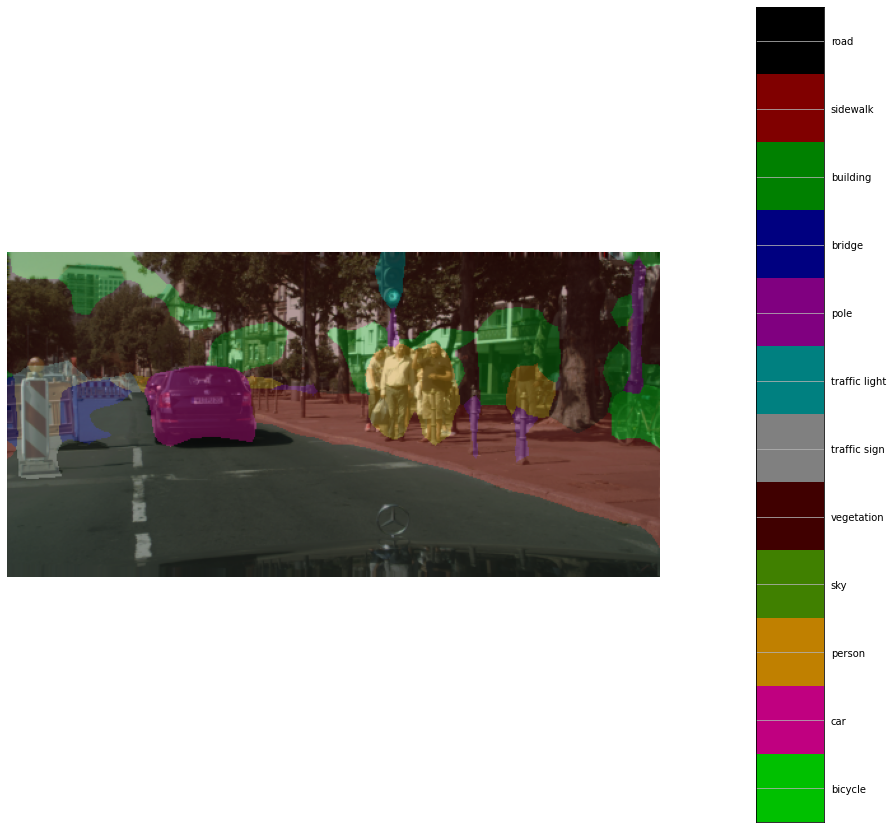

In [7]:
display(padded_image[0:resized_height,:,:], output_data[0:resized_height,:])